1. SIFT Image-based Object Detection

In [ ]:
# -*- coding: utf-8 -*-
"""SIFT_object_detection

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1DOS9nj2fjdU3qyiL7vou88tDiOlADhmf

1. SIFT Image-based Object Detection
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files
from IPython.display import display, HTML
import base64
import io
from PIL import Image

def detect_object(query_img, target_img):
    """
    Detect an object from a query image in a target image using SIFT features and FLANN matcher.

    Args:
        query_img: Query image containing the object to detect
        target_img: Target image where we want to find the object

    Returns:
        Displayed image with matched points drawn
    """
    # Convert images to grayscale for feature detection
    query_gray = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)
    target_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors with SIFT
    query_keypoints, query_descriptors = sift.detectAndCompute(query_gray, None)
    target_keypoints, target_descriptors = sift.detectAndCompute(target_gray, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)  # or pass empty dictionary

    # Use FLANN matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(query_descriptors, target_descriptors, k=2)

    # Apply ratio test to get good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:  # Lowe's ratio test
            good_matches.append(m)

    # Extract location of good matches
    if len(good_matches) >= 4:
        query_points = np.float32([query_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        target_points = np.float32([target_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Find homography
        M, mask = cv2.findHomography(query_points, target_points, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()

        # Height and width of query image
        h, w = query_gray.shape

        # Define corners of the query image
        pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

        # Transform corners to target image coordinates
        dst = cv2.perspectiveTransform(pts, M)

        # Draw the outline of the query object in the target image
        target_with_outline = target_img.copy()
        cv2.polylines(target_with_outline, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

        # Draw all the good matches on the target image
        target_with_points = target_img.copy()
        for i, point in enumerate(target_points):
            if matchesMask[i]:
                # Extract the coordinates from the point
                x, y = point[0]
                # Draw a circle at each matched point
                cv2.circle(target_with_points, (int(x), int(y)), 5, (0, 0, 255), -1)

        # Return results
        return {
            'target_with_outline': target_with_outline,
            'target_with_points': target_with_points,
            'good_matches': len(good_matches),
            'query_keypoints': len(query_keypoints),
            'target_keypoints': len(target_keypoints)
        }
    else:
        print("Not enough good matches found - {}/{}".format(len(good_matches), 4))
        return None

def visualize_results(results, query_img, target_img):
    """
    Visualize the results of object detection

    Args:
        results: Dictionary containing results from detect_object function
        query_img: Original query image
        target_img: Original target image
    """
    if results is None:
        print("No results to visualize")
        return

    # Create figure with 4 subplots
    fig, ax = plt.subplots(2, 2, figsize=(15, 12))

    # Display the query image
    ax[0, 0].imshow(cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB))
    ax[0, 0].set_title('Query Image')
    ax[0, 0].axis('off')

    # Display the target image
    ax[0, 1].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
    ax[0, 1].set_title('Target Image')
    ax[0, 1].axis('off')

    # Display the target image with outline
    ax[1, 0].imshow(cv2.cvtColor(results['target_with_outline'], cv2.COLOR_BGR2RGB))
    ax[1, 0].set_title('Object Outline')
    ax[1, 0].axis('off')

    # Display the target image with matched points
    ax[1, 1].imshow(cv2.cvtColor(results['target_with_points'], cv2.COLOR_BGR2RGB))
    ax[1, 1].set_title('Matched Points')
    ax[1, 1].axis('off')

    plt.tight_layout()
    plt.suptitle(f"Found {results['good_matches']} good matches out of {results['query_keypoints']} query keypoints", y=0.98)
    plt.show()



2. File Upload and Processing

In [ ]:
"""2. File Upload and Processing"""

# Function to upload and process images
def upload_and_process_images():
    print("Upload your query image (the object you want to detect):")
    uploaded_query = files.upload()
    query_filename = next(iter(uploaded_query))
    query_img = cv2.imdecode(np.frombuffer(uploaded_query[query_filename], np.uint8), cv2.IMREAD_COLOR)

    print("\nUpload your target image (where you want to find the object):")
    uploaded_target = files.upload()
    target_filename = next(iter(uploaded_target))
    target_img = cv2.imdecode(np.frombuffer(uploaded_target[target_filename], np.uint8), cv2.IMREAD_COLOR)

    # Display SIFT keypoints on query image
    query_gray = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    query_keypoints = sift.detect(query_gray, None)
    img_keypoints = cv2.drawKeypoints(query_img, query_keypoints, None,
                                     flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img_keypoints, cv2.COLOR_BGR2RGB))
    plt.title(f"Query Image with {len(query_keypoints)} SIFT Keypoints")
    plt.axis('off')
    plt.show()

    # Detect object
    print("Detecting object in target image...")
    results = detect_object(query_img, target_img)

    # Display results
    visualize_results(results, query_img, target_img)

# NEW FUNCTION: Detect object in video
# Fix for the SIFT Object Detection in Video function

def detect_object_in_uploaded_video(query_img):
    """
    Detect an object in an uploaded video using SIFT features and color detection.

    Args:
        query_img: Query image containing the object to detect

    Returns:
        HTML display with the processed video
    """
    # Make sure to import files explicitly inside the function
    from google.colab import files

    print("\nUpload your target video (where you want to find the object):")
    uploaded_video = files.upload()
    video_filename = next(iter(uploaded_video))

    # Save the uploaded video to a temporary file
    with open(video_filename, 'wb') as f:
        f.write(uploaded_video[video_filename])

    # Open the video file
    cap = cv2.VideoCapture(video_filename)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error opening video file")
        return

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Set up video writer for output video
    output_filename = 'output_' + video_filename
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # codec
    out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

    # Prepare SIFT detection for query image
    query_gray = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    query_keypoints, query_descriptors = sift.detectAndCompute(query_gray, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # For color detection
    # Extract dominant color from query image
    pixels = np.float32(query_img.reshape(-1, 3))
    n_colors = 1
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    dominant_color = palette[0].astype(np.uint8)
    print(f"Dominant color in query image: {dominant_color}")

    # Convert to HSV color space for better color detection
    dominant_color_bgr = np.uint8([[dominant_color]])
    dominant_color_hsv = cv2.cvtColor(dominant_color_bgr, cv2.COLOR_BGR2HSV)[0][0]

    # Create color range for detection
    # Create wider range for better detection
    h_value = dominant_color_hsv[0]
    h_range = 15  # Range for hue
    s_range = 50  # Range for saturation
    v_range = 50  # Range for value

    # FIX: Explicitly convert the arrays to np.uint8 data type
    lower_hsv = np.array([max(0, h_value - h_range),
                          max(0, dominant_color_hsv[1] - s_range),
                          max(0, dominant_color_hsv[2] - v_range)], dtype=np.uint8)
    upper_hsv = np.array([min(179, h_value + h_range),
                          min(255, dominant_color_hsv[1] + s_range),
                          min(255, dominant_color_hsv[2] + v_range)], dtype=np.uint8)

    print(f"HSV range for detection: Lower {lower_hsv}, Upper {upper_hsv}")

    print(f"Processing video with {total_frames} frames...")

    # Process the video frame by frame
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Update progress
        frame_count += 1
        if frame_count % 10 == 0:
            print(f"Processing frame {frame_count}/{total_frames} ({frame_count/total_frames*100:.1f}%)")

        # Color detection
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        color_mask = cv2.inRange(hsv_frame, lower_hsv, upper_hsv)

        # Apply morphological operations to clean up the mask
        kernel = np.ones((5, 5), np.uint8)
        color_mask = cv2.erode(color_mask, kernel, iterations=1)
        color_mask = cv2.dilate(color_mask, kernel, iterations=2)

        # Find contours in the mask
        contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw contours that are large enough (to filter out noise)
        min_contour_area = 100  # Adjust as needed
        detected_by_color = False

        for contour in contours:
            area = cv2.contourArea(contour)
            if area > min_contour_area:
                # Draw the contour
                cv2.drawContours(frame, [contour], -1, (0, 255, 0), 3)
                detected_by_color = True

                # For circular objects, try to fit a circle
                if len(contour) >= 5:  # Need at least 5 points to fit an ellipse
                    try:
                        (x, y), radius = cv2.minEnclosingCircle(contour)
                        center = (int(x), int(y))
                        radius = int(radius)
                        cv2.circle(frame, center, radius, (0, 255, 0), 2)
                        cv2.putText(frame, "Object Detected", center,
                                  cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    except:
                        pass

        # Only use SIFT if color detection didn't work
        if not detected_by_color and frame_count % 5 == 0:  # Only run SIFT every 5 frames to improve performance
            # Convert frame to grayscale
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Find keypoints and descriptors in the current frame
            frame_keypoints, frame_descriptors = sift.detectAndCompute(frame_gray, None)

            if frame_keypoints and len(frame_keypoints) > 0 and frame_descriptors is not None and query_descriptors is not None:
                # Match descriptors
                try:
                    matches = flann.knnMatch(query_descriptors, frame_descriptors, k=2)

                    # Apply ratio test
                    good_matches = []
                    for m, n in matches:
                        if m.distance < 0.75 * n.distance:
                            good_matches.append(m)

                    # Draw detected object if enough good matches
                    if len(good_matches) >= 4:
                        query_points = np.float32([query_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                        frame_points = np.float32([frame_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

                        # Find homography
                        M, mask = cv2.findHomography(query_points, frame_points, cv2.RANSAC, 5.0)

                        if M is not None:
                            # Define corners of the query image
                            h, w = query_gray.shape
                            pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

                            # Transform corners to frame coordinates
                            dst = cv2.perspectiveTransform(pts, M)

                            # Draw outline on the frame
                            cv2.polylines(frame, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

                            # Add a label
                            cv2.putText(frame, "Object Detected", (10, 30),
                                      cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                except Exception as e:
                    print(f"Error in SIFT processing for frame {frame_count}: {e}")

        # Write frame to output video
        out.write(frame)

    # Release resources
    cap.release()
    out.release()

    print(f"Video processing complete. Output saved as {output_filename}")

    # Display the first frame as a preview
    cap = cv2.VideoCapture(output_filename)
    ret, frame = cap.read()
    if ret:
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title("Preview of Processed Video (First Frame)")
        plt.axis('off')
        plt.show()
    cap.release()

    # Return a download link for the processed video
    files.download(output_filename)

    return HTML(f'<p>Video processing complete. The video has been automatically downloaded or use the link below:</p><a href="./files/{output_filename}" download>Download Processed Video</a>')

Usage Section

SIFT Object Detection Implementation
This notebook implements the Scale-Invariant Feature Transform (SIFT) algorithm
for object detection using OpenCV.

Options:
1. Detect an object in a target image
2. Detect an object in a video

Enter your choice (1 or 2): 1
Upload your query image (the object you want to detect):


Saving Screenshot 2025-04-19 211334.png to Screenshot 2025-04-19 211334 (1).png

Upload your target image (where you want to find the object):


Saving Screenshot 2025-04-19 211325.png to Screenshot 2025-04-19 211325 (1).png


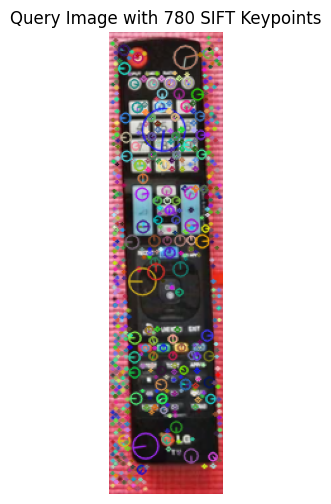

Detecting object in target image...


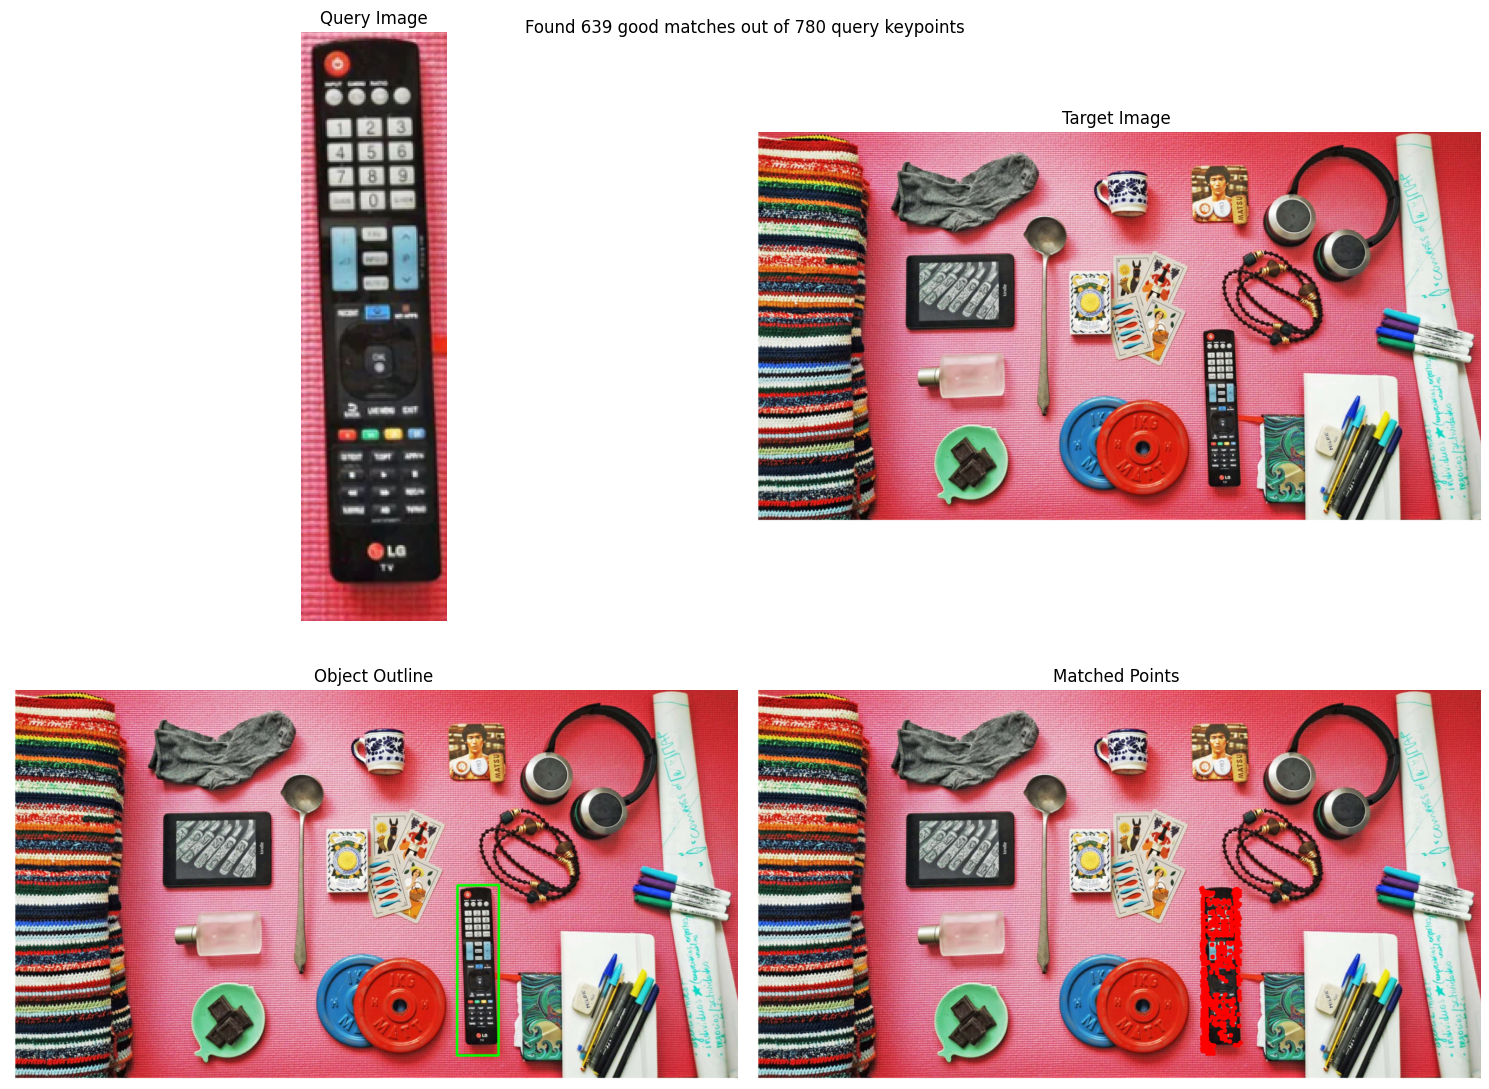

In [ ]:
"""Usage Section"""

# Main execution block
print("SIFT Object Detection Implementation")
print("===================================")
print("This notebook implements the Scale-Invariant Feature Transform (SIFT) algorithm")
print("for object detection using OpenCV.")
print("\nOptions:")
print("1. Detect an object in a target image")
print("2. Detect an object in a video")

choice = input("\nEnter your choice (1 or 2): ")

if choice == '1':
    upload_and_process_images()
elif choice == '2':
    print("Upload your query image (the object you want to detect):")
    uploaded_query = files.upload()
    query_filename = next(iter(uploaded_query))
    query_img = cv2.imdecode(np.frombuffer(uploaded_query[query_filename], np.uint8), cv2.IMREAD_COLOR)

    # Display keypoints on query image
    query_gray = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    query_keypoints = sift.detect(query_gray, None)
    img_keypoints = cv2.drawKeypoints(query_img, query_keypoints, None,
                                     flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img_keypoints, cv2.COLOR_BGR2RGB))
    plt.title(f"Query Image with {len(query_keypoints)} SIFT Keypoints")
    plt.axis('off')
    plt.show()

    display(detect_object_in_uploaded_video(query_img))
else:
    print("Invalid choice. Please run the cell again and select 1 or 2.")